In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp # for reference

import autograd.numpy as np
from neuralsolver import NNSolver

import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt
import time

# figure settings
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams['legend.fontsize'] = 13

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 15

In [2]:
def plot_loss_compare(model, maxiter = 1000, iprint = 200):
    model.reset_weights()
    save_init_paras_list = model.params_list
    save_init_flattened_params = model.flattened_params
    
    
    methods = ['CG','BFGS','L-BFGS-B']
    
    plt.figure(figsize=(8,6))
    for method in methods:
        
        model.params_list = save_init_paras_list
        model.flattened_params = save_init_flattened_params
        
        start_time = time.time()
        model.train(method = method, maxiter=maxiter, iprint=iprint)
        duration = time.time() - start_time
        
        plt.semilogy(range(len(model.loss)), model.loss, label = method + ' (time = {}s'.format(round(duration,2)) + ')')
        
    plt.legend()
    plt.title("Log Loss Comparision", fontsize = 20)
    plt.xlabel("Iteration")
    plt.ylabel("Log Loss")
    plt.show()

# Problem Definition

In [19]:
# define ODE problem
# Lorenz attractor system

def f(t, y):
    # y[0]=x, y[1]=y, y[2]=z
    a = 10
    b = 8/3
    c = 28
    return [a*(y[1] - y[0]), y[0]*(c-y[2])-y[1], y[0]*y[1]-b*y[2]]

t = np.linspace(0, 0.5, 200).reshape(-1, 1) #increase training points

y0_list = [1, 5, 10] # number of prey and predactor respectively

# Reference solution

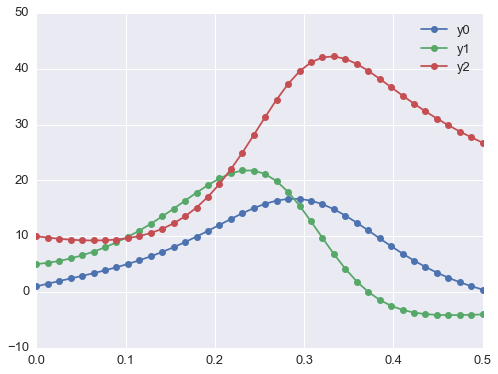

In [11]:
# reference solution using scipy package
sol = solve_ivp(f, [t.min(), t.max()], y0_list, 
                t_eval=t.ravel(), method='Radau', rtol=1e-5)
plt.plot(sol.t, sol.y[0], marker='o', label='y0')
plt.plot(sol.t, sol.y[1], marker='o', label='y1')
plt.plot(sol.t, sol.y[2], marker='o', label='y2')
plt.legend()

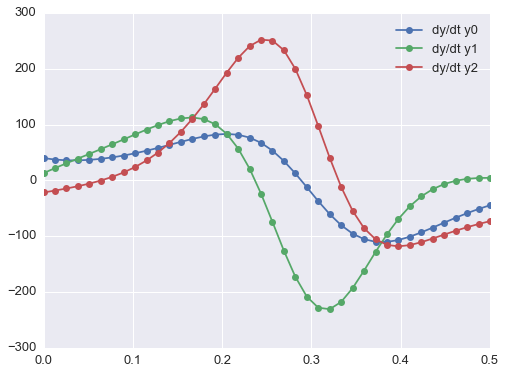

In [12]:
# reference solution using scipy package
plt.plot(sol.t, f(sol.t, sol.y)[0], marker='o', label='dy/dt y0')
plt.plot(sol.t, f(sol.t, sol.y)[1], marker='o', label='dy/dt y1')
plt.plot(sol.t, f(sol.t, sol.y)[2], marker='o', label='dy/dt y2')
plt.legend()

# Neural Net Training

In [20]:
nn = NNSolver(f, t, y0_list, n_hidden=30)
nn

Neural ODE Solver 
Number of equations:       3 
Initial condition y0:      [1, 5, 10] 
Numnber of hidden units:   30 
Number of training points: 200 

In [14]:
nn.reset_weights()
%time nn.train(maxiter=1000, iprint=100)

iteration: 0 loss:  2065.92597261
iteration: 100 loss:  645.059717303
iteration: 200 loss:  425.175062436
iteration: 300 loss:  0.123907303908
iteration: 400 loss:  0.00811406472896
iteration: 500 loss:  0.00112530966941
iteration: 600 loss:  0.000529048208425
iteration: 700 loss:  0.000239624113086
iteration: 800 loss:  0.000145408506091
iteration: 900 loss:  8.58021411897e-05
         Current function value: 0.000066
         Iterations: 1000
         Function evaluations: 1094
         Gradient evaluations: 1094
CPU times: user 26.1 s, sys: 530 ms, total: 26.6 s
Wall time: 24.3 s


# Verifying training set

In [15]:
y_pred_list, dydt_pred_list = nn.predict()

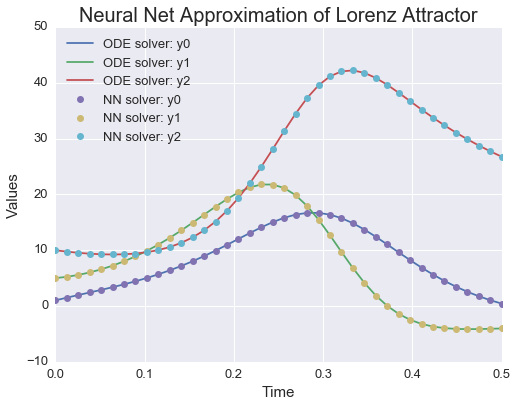

In [16]:
plt.figure(figsize= (8, 6))
# scipy sol
plt.plot(sol.t, sol.y[0], label='ODE solver: y0')
plt.plot(sol.t, sol.y[1], label='ODE solver: y1')
plt.plot(sol.t, sol.y[2], label='ODE solver: y2')

# nn soln
plt.plot(t, y_pred_list[0], 'o', label='NN solver: y0')
plt.plot(t, y_pred_list[1], 'o', label='NN solver: y1')
plt.plot(t, y_pred_list[2], 'o', label='NN solver: y2')

plt.legend(loc = "best")
plt.title('Neural Net Approximation of Lorenz Attractor')
plt.ylabel('Values')
plt.xlabel('Time')

In [17]:
np.mean([sqrt(mean_squared_error(sol.y[i], y_pred_list[i])) for i in range(3)])

5.9288067027098822e-05

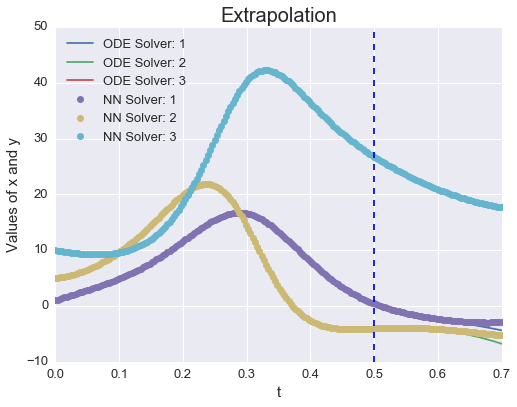

In [11]:
# not used 
t_test = np.linspace(0., 0.7, 200).reshape(-1,1)

sol = solve_ivp(f, [t_test.min(), t_test.max()], y0_list, method='Radau', rtol=1e-5)
y_pred_list, dydt_pred_list = nn.predict(t=t_test)
plt.figure(figsize=(8, 6))
plt.plot(sol.t, sol.y[0], label='ODE Solver: 1')
plt.plot(sol.t, sol.y[1], label='ODE Solver: 2')
plt.plot(sol.t, sol.y[2], label='ODE Solver: 3')

plt.plot(t_test, y_pred_list[0], 'o', label='NN Solver: 1')
plt.plot(t_test, y_pred_list[1], 'o', label='NN Solver: 2')
plt.plot(t_test, y_pred_list[2], 'o', label='NN Solver: 3')
plt.axvline(x = 0.5 , linestyle = '--')
plt.legend(loc = 'best')
plt.title('Extrapolation')
plt.ylabel('Values of x and y')
plt.xlabel('t')

# Performance over 100 Fittings

In [6]:
res_arr = []
for _ in range(100):
    nn = NNSolver(f, t, y0_list, n_hidden=20)
    nn.reset_weights()
    nn.train(maxiter=500)
    y_pred_list, dydt_pred_list = nn.predict()
    res_arr.append(np.mean([sqrt(mean_squared_error(sol.y[i], y_pred_list[i])) for i in range(3)]))

iteration: 0 loss:  1690.78267932
iteration: 200 loss:  470.296335352
iteration: 400 loss:  0.0701619702665
         Current function value: 0.011525
         Iterations: 500
         Function evaluations: 549
         Gradient evaluations: 549
iteration: 0 loss:  1693.75072694
iteration: 200 loss:  258.418784901
iteration: 400 loss:  0.0986435419928
         Current function value: 0.012233
         Iterations: 500
         Function evaluations: 551
         Gradient evaluations: 551
iteration: 0 loss:  1859.5338078
iteration: 200 loss:  482.773683298
iteration: 400 loss:  0.0674112286108
         Current function value: 0.021090
         Iterations: 500
         Function evaluations: 564
         Gradient evaluations: 564
iteration: 0 loss:  1807.70722321
iteration: 200 loss:  476.453574475
iteration: 400 loss:  0.0968411471857
         Current function value: 0.015087
         Iterations: 500
         Function evaluations: 562
         Gradient evaluations: 562
iteration: 0 loss:  1

(array([ 98.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.]), array([  4.31276275e-04,   1.51947704e+00,   3.03852281e+00,
         4.55756857e+00,   6.07661434e+00,   7.59566011e+00,
         9.11470587e+00,   1.06337516e+01,   1.21527974e+01,
         1.36718432e+01,   1.51908889e+01]), <a list of 10 Patch objects>)


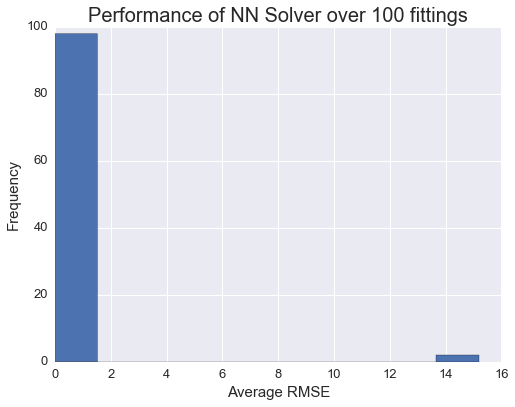

In [7]:
plt.figure(figsize= (8, 6))
figr = plt.hist(res_arr)
plt.title('Performance of NN Solver over 100 fittings')
plt.xlabel('Average RMSE')
plt.ylabel('Frequency')
print (figr)

# Compare across different optimization methods¶

iteration: 0 loss:  1979.9612186
iteration: 200 loss:  656.016216899
iteration: 400 loss:  648.066293882
iteration: 600 loss:  644.169081865
iteration: 800 loss:  624.343406344
         Current function value: 608.851528
         Iterations: 1000
         Function evaluations: 1911
         Gradient evaluations: 1911
iteration: 0 loss:  1979.9612186
iteration: 200 loss:  447.79522943
iteration: 400 loss:  0.00325423049462
iteration: 600 loss:  0.00032576673468
iteration: 800 loss:  0.00015997594861
         Current function value: 0.000048
         Iterations: 1000
         Function evaluations: 1094
         Gradient evaluations: 1094
iteration: 0 loss:  1979.9610563
iteration: 200 loss:  641.43307419
iteration: 400 loss:  598.720982752
iteration: 600 loss:  591.457882107
iteration: 800 loss:  569.854597182
iteration: 1000 loss:  546.105669406


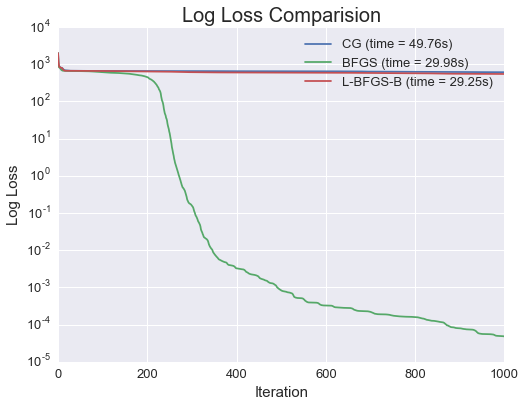

In [21]:
plot_loss_compare(nn)